### LeNet in Pytorch

+ This notebook shows how to use PyTorch (and TorchVision) for Image Classification.  

+ The dataset used is CIFAR-10. 

+ CIFAR-10 defines 10 classes and contains 6K images per class, for a total of 60K images. 

+ 50K Images are used for training and 10K for testing.

+ The images are (32,32) RGBs

        + https://www.cs.toronto.edu/~kriz/cifar.html

+ Images are obtained directly from torchvision.datasets.CIFAR10(args) 

+ The notebook shows how to implement in Pytorch LeNet from scratch.

+ The last cells show how to evaluate the model in general and also there is a cell where the model performance is valuated in terms of each of the 10 classes.

+ The code shows how to connect the model to the GPU, and how to ensire that the data is also loaded into the GPU




In [ ]:
# Get general purpose APIs first
import numpy as np
import matplotlib.pyplot as plt

# load the Pytorch APIs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cn1 = nn.Conv2d(3, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# load the model into the GPU is availabble 
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print("LeNet Model params = ", count_params( model))

LeNet Model params =  62006


In [ ]:

locBatchSize = 64
# locBatchSize = 4096

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize the data.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=locBatchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=locBatchSize,
                                         shuffle=False, num_workers=2)

# order is important ! 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


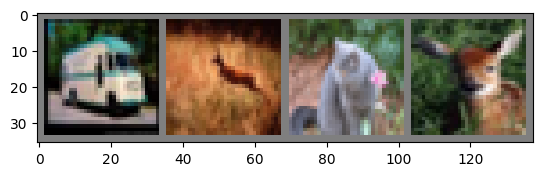

 truck || deer || cat || deer


In [7]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))



In [ ]:
epochs = 20  # Adjust as needed

# data is loaded into GPU via data[i].to(device)
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.929
[1,   400] loss: 1.646
[1,   600] loss: 1.549
[2,   200] loss: 1.391
[2,   400] loss: 1.355
[2,   600] loss: 1.333
[3,   200] loss: 1.257
[3,   400] loss: 1.234
[3,   600] loss: 1.219
[4,   200] loss: 1.168
[4,   400] loss: 1.146
[4,   600] loss: 1.146
[5,   200] loss: 1.076
[5,   400] loss: 1.100
[5,   600] loss: 1.087
[6,   200] loss: 1.027
[6,   400] loss: 1.034
[6,   600] loss: 1.049
[7,   200] loss: 0.984
[7,   400] loss: 0.990
[7,   600] loss: 0.993
[8,   200] loss: 0.939
[8,   400] loss: 0.934
[8,   600] loss: 0.969
[9,   200] loss: 0.898
[9,   400] loss: 0.927
[9,   600] loss: 0.911
[10,   200] loss: 0.860
[10,   400] loss: 0.883
[10,   600] loss: 0.895
[11,   200] loss: 0.828
[11,   400] loss: 0.844
[11,   600] loss: 0.881
[12,   200] loss: 0.799
[12,   400] loss: 0.819
[12,   600] loss: 0.830
[13,   200] loss: 0.790
[13,   400] loss: 0.799
[13,   600] loss: 0.817
[14,   200] loss: 0.752
[14,   400] loss: 0.767
[14,   600] loss: 0.783
[15,   200] loss: 0

### Effect of Batch Size

+ batch_size = 64   => accuracy around 65%
+ batch_size = 4096 => accuracy around 50%


In [11]:
## Save the model to disk 

modelPath = '/drv3/hm3/code/python/torch/'
modelName = modelPath + "LeNet_Cifar10.pth"
torch.save(model.state_dict(), modelName)

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 63.75 %


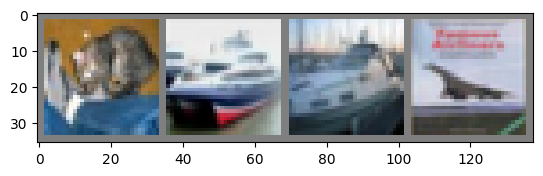

Label:     cat  ship  ship plane
Prediction:    cat  ship  ship plane


/tmp/ipykernel_25965/2218482327.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_cached.load_state_dict(torch.load(modelName))


In [23]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)
# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:  ', ' '.join('%5s' %
            classes[ground_truth[j]]
            for j in range(4)))

# load model from disk 
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(modelName))
# model inference
op = lenet_cached(im)
# print predictions
_, pred = torch.max(op, 1)
print('Prediction: ', ' '.join('%5s' % classes[pred[j]]
                        for j in range(4)))

In [15]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()
print('Model accuracy on 10000 images from test dataset: %d %%'\
            % (100 * success / counter))

Model accuracy on 10000 images from test dataset: 63 %


In [ ]:
## Eval per-class accuracy 

class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range( len(ground_truth)) :
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1
for i in range(10):
    print('Accuracy for class %5s : %2d %%' % (
            classes[i], 100 * class_sucess[i] / class_counter[i]))

Accuracy for class plane : 68 %
Accuracy for class   car : 71 %
Accuracy for class  bird : 54 %
Accuracy for class   cat : 46 %
Accuracy for class  deer : 61 %
Accuracy for class   dog : 52 %
Accuracy for class  frog : 72 %
Accuracy for class horse : 66 %
Accuracy for class  ship : 71 %
Accuracy for class truck : 71 %
